In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

import keras
from keras import layers
from keras.utils import to_categorical

from wordcloud import WordCloud

from html import unescape

Using TensorFlow backend.


In [3]:
!python -m spacy download en_core_web_lg

import spacy
nlp = spacy.load('en_core_web_lg')

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/conda/lib/python3.6/socket.py", line 745, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 346, in _make_request
    self._validate_conn(conn)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.p

In [4]:
### plotting ###
# prettier and larger basic graphs
sns.set(rc={
    'figure.figsize':(18,8),
    'axes.titlesize':14,
})

### pandas ###
# no need to see many decimal places and makes nicer horizontal fits :-)
pd.options.display.float_format = '{:.3f}'.format
# pd.options.display.precision = 3
# make the tables more compact vertically, too
pd.options.display.max_rows = 20

### numpy ###
# same as for pandas - max. 3 decimal places
np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})
# np.set_printoptions(precision=3)

In [5]:
print(os.listdir("../input"))

['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [6]:
reviews_df = pd.read_csv('../input/drugsComTrain_raw.csv')
reviews_df

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [7]:
def clean_review(text):
    # replace HTML escaped characters and strip outer quotes and spaces
    return unescape(
        text.strip(' "\'').replace('/', ' ')
    )

reviews_df.review = reviews_df.review.apply(clean_review)

In [11]:
reviews_nlp = nlp.pipe(
    texts=reviews_df.review.values,
    disable=['tagger', 'parser', 'ner'],
)

reviews_df['review_seq'] = None
reviews_df['review_vector'] = None

for index, review in zip(reviews_df.index, reviews_nlp):
    # transform the review to a sequence of vectors
    seq = [
        hash(token.lemma_) % VOCABULARY_SIZE
        for token in review
    ]
    reviews_df.at[index, 'review_seq'] = seq
    reviews_df.at[index, 'review_vector'] = review.vector

In [10]:
MAX_SEQUENCE_LENGTH = 200
VOCABULARY_SIZE = 2137

In [12]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110)

In [13]:
text = ' '.join(reviews_df.review)

In [14]:
wordcloud.generate(text)

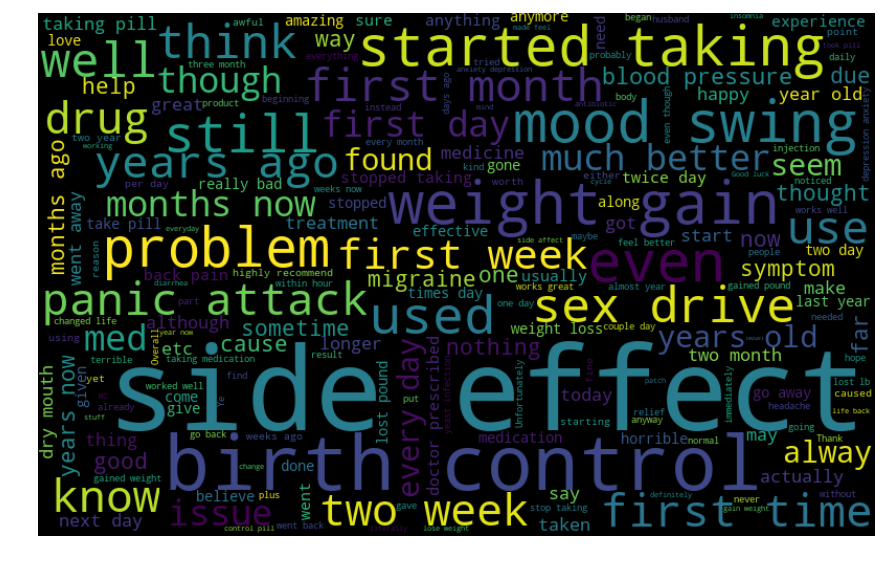

In [15]:

plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [18]:
sequence_lenghts = np.array([len(s) for s in reviews_df.review_seq])

In [ ]:
sns.distplot(
    sequence_lenghts,
    hist_kws=dict(label='Histogram'),
    kde=True,
    kde_kws=dict(label='Kernel Density'),
    rug=True,
    norm_hist=False,
    rug_kws=dict(color='orangered', label='Sample'),
    axlabel='Sequence Lenght',
)
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='yellowgreen', label='Sequence Cutoff Lenght')
plt.ylabel('Density')
plt.legend();

In [ ]:
sns.distplot(sequence_lenghts, kde=False)
plt.gca().set_yscale('log')
plt.axvline(x=MAX_SEQUENCE_LENGTH, color='yellowgreen');

In [19]:
sum(sequence_lenghts > MAX_SEQUENCE_LENGTH)/len(sequence_lenghts)

0.0022505068290172786

In [20]:
x_train = keras.preprocessing.sequence.pad_sequences(reviews_df.review_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [22]:
y_train = reviews_df.rating.values / 10

In [23]:
# plotting

def plot_history(history, skip_first_n_epochs=0):
    """Show information about the training"""
    
    # plot every train-valid metric pair separately
    for metric in history:
        if not metric.startswith('val_'):
            x = np.arange(len(history[metric]))+1

            y_train = history[metric][skip_first_n_epochs:]
            y_valid = history['val_'+metric][skip_first_n_epochs:]

            # make the plots
            plt.plot(x, y_train)
            plt.plot(x, y_valid)

            # add a legend
            plt.legend([metric, 'val_'+metric], fontsize='large')

            # title with min/max stats
            plt.title(
                f'{metric.upper()} - '
                f'min/max [train: {min(y_train):.3f}/{max(y_train):.3f}, '
                f'valid: {min(y_valid):.3f}/{max(y_valid):.3f}]'
            )
            
            # label and show
            plt.xlabel('epoch')
            plt.show()

In [31]:
model = keras.models.Sequential()
model.add(layers.Embedding(VOCABULARY_SIZE, output_dim=128))
model.add(layers.CuDNNLSTM(128))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         273536    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 406,273
Trainable params: 406,017
Non-trainable params: 256
_________________________________________________________________


In [32]:
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae', 'mse'],
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=256,
    epochs=20,
    verbose=1,
    validation_split=0.25,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            'model-epoch_{epoch:02d}-val_loss_{val_loss:.2f}.hdf5',
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            period=1,
        ),
    ],
)

plot_history(history.history)